In [1]:
import theano.tensor as T
from theano import config, shared
import numpy as np

a = 5 
b = 2
c = 0.4
N = 2000
s_noise = 0.2

x0 = np.linspace(-3.0, 3.0, num=N);
x1 = np.sin(0.5 * x0)
x2 = np.cos(3 * x0)

X = np.array([x1, x2]).T
y = a * x1 + b *x2 + c

nu = np.random.randn(N,) * s_noise

z = y + nu

y_str = '$f(x)={%g sin(0.5x)} + {%g cos(3x)} + {%g} = {%g x_1} + {%g x_2} + {%g}$' % (a, b, c, a, b, c)

n_train = int(N * 0.5)
i_test = N - n_train

y_train = z[0:n_train][:,np.newaxis]
y_test = z[i_test:N][:,np.newaxis]
X_train = X[0:n_train]
X_test = X[i_test:N]

fx_train = y[0:n_train][:,np.newaxis]
fx_test = y[i_test:N][:,np.newaxis]

<IPython.core.display.Javascript object>


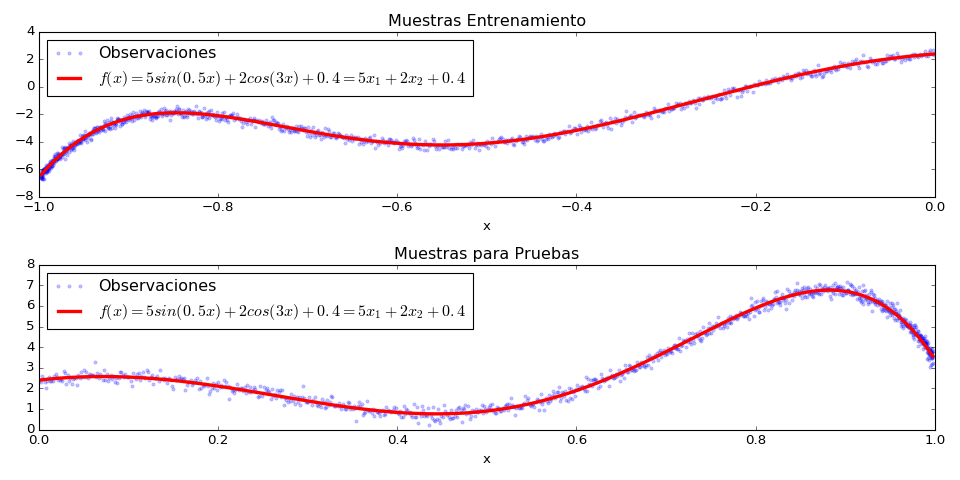

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=80)
ax = plt.subplot(211)
ax.plot(X_train[:,0], y_train, 'b.', alpha=0.25, label='Observaciones')
ax.plot(X_train[:,0], fx_train, '-r', lw=3, label=y_str)
plt.title('Muestras Entrenamiento')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

ax = plt.subplot(212)
ax.plot(X_test[:,0], y_test, 'b.', alpha=0.25, label='Observaciones')
ax.plot(X_test[:,0], fx_test, '-r', lw=3, label=y_str)
plt.title('Muestras para Pruebas')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

In [3]:
## Modelo
# y = a x_1 + b x_2 + c = W X

import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.metrics import *
from deepensemble.utils import *

from collections import OrderedDict

config.optimizer = 'None'
config.exception_verbosity = 'high'

# Silverman
s = ITLFunctions.silverman(y_train).eval()

print("Silverman: %g" % s)

# Create MLP
mlp = Sequential("MLP")  # by default is a regressor
mlp.add_layer(Dense(n_input=X_train.shape[1], n_output=1, activation=ActivationFunctions.linear))
mlp.append_cost(cip_relevancy, name='Relevancy', s=s, dist='CS')
mlp.append_score(mutual_information_parzen, name='Mutual Information')

# Normal Training
mlp.set_update(sgd, name='SGD', learning_rate=-0.1)

mlp.compile(fast=False)

mlp.get_layers()[0].get_W().set_value(np.array([a - 0.8, b - 0.7])[:, np.newaxis])
mlp.get_layers()[0].get_b().set_value(np.array([c - 0.1]))

metrics_mlp = FactoryMetrics.get_metric(mlp)                    

# training
metrics = mlp.fit(X_train, y_train, max_epoch=500, batch_size=32, early_stop=False, valid_size=0.2, 
                  update_sets=False, criterion_update_params = 'cost', maximization_criterion=True)

# Compute metricstrain
metrics_mlp.append_metric(metrics)

print()

ap, bp = mlp.get_layers()[0].get_W().eval()
cp = mlp.get_layers()[0].get_b().eval()
print("a=%g, ap=%g" % (a, ap))
print("b=%g, bp=%g" % (b, bp))
print("c=%g, cp=%g" % (c, cp))

Silverman: 0.551432
Start Compile MLP  - elapsed: 0.79 [s]
MLP - fold: 1, epoch:[####################] 500/500 elapsed: 10.09[s] - left: 0.00[s] | score: 0.2794 / 0.0449

a=5, ap=4.25076
b=2, bp=1.94703
c=0.4, cp=0.3


<IPython.core.display.Javascript object>


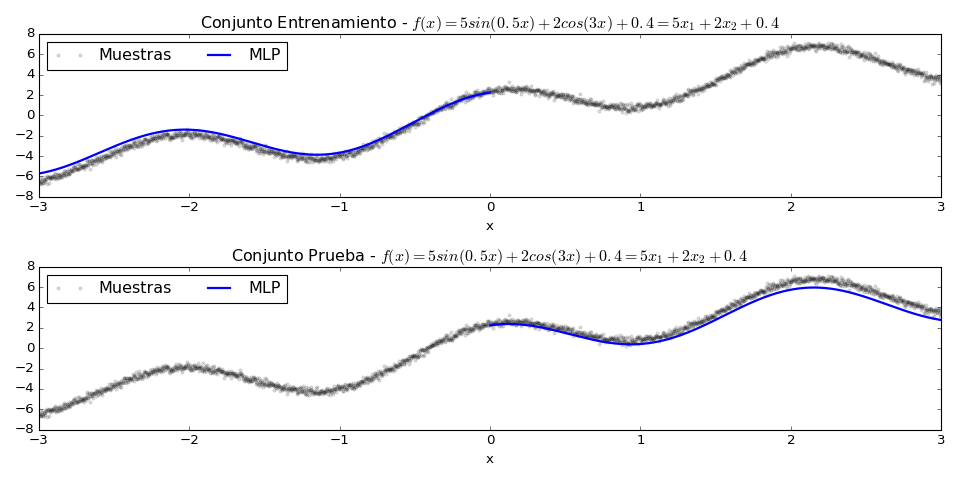

In [4]:
fig = plt.figure(figsize=(12, 6), dpi=80)

t = x0[0:n_train][:,np.newaxis]
plt.subplot(211)
plt.plot(x0, z, 'k.', alpha=0.15,  label='Muestras')
plt.plot(t, mlp.predict(X_train), lw=2, label='MLP')
plt.title('Conjunto Entrenamiento - %s' % y_str)
plt.xlabel('x')
plt.xlim([-3,3])
plt.legend(loc='best', ncol=5)


t = x0[i_test:N]
plt.subplot(212)
plt.plot(x0, z, 'k.', alpha=0.15, label='Muestras')
plt.plot(t, mlp.predict(X_test), lw=2, label='MLP')
plt.title('Conjunto Prueba - %s' % y_str)
plt.xlabel('x')
plt.xlim([-3,3])
plt.legend(loc='best', ncol=5)

plt.tight_layout()

<IPython.core.display.Javascript object>


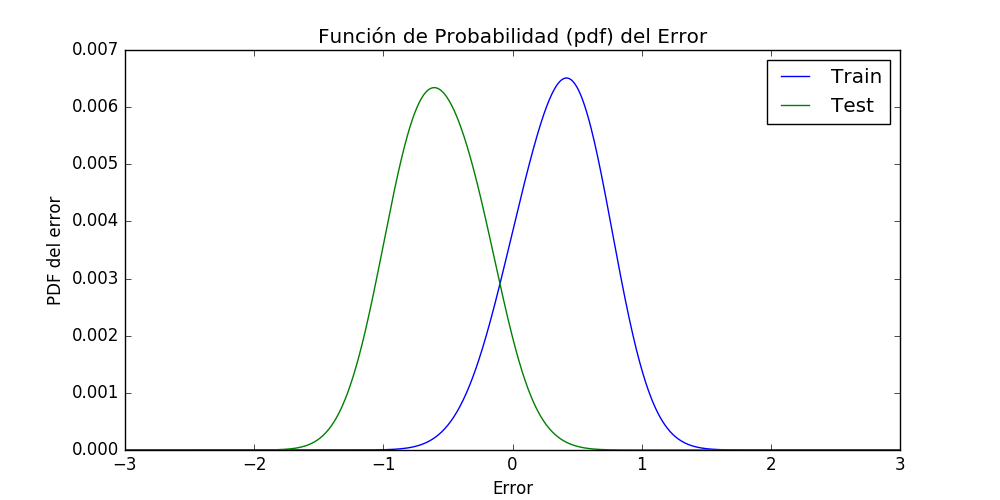

In [5]:
from sklearn.neighbors.kde import KernelDensity

def plot_pdf_error(pred, target, label_plot, ax, fig, n_points=1000, xmin=-3, xmax=3):
    error = pred - target
    N = len(error)
    s = 1.06 * np.std(error) / np.power(N, 0.2)  # Silverman
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde.fit(error)
    x_plot = np.linspace(xmin, xmax, n_points)[:, np.newaxis]
    y_plot = np.exp(kde.score_samples(x_plot))
    ax.plot(x_plot, y_plot / np.sum(y_plot), label=label_plot)
    
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(mlp.predict(X_train), y_train, 'Train', ax, fig)
plot_pdf_error(mlp.predict(X_test), y_test, 'Test', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error")
plt.legend()